# Analysis of the relation between the sensation level difference (SL BC - SL AC) with signal at BCD side and the fitting appraisal 

7 March 2021 Guido Cattani

In [1]:
from pathlib import Path
import pandas as pd
from scipy.stats import mannwhitneyu as mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_AC_thresholds():
    # function to read AC thersholds data
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Headband/AC_thresholds.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, sheet_name=0, header=0, nrows=85)
    df = df.drop(['Unnamed: 0'], axis=1)
    new_names = {
             'AC_125':'AC_125_Hz', 'AC_250':'AC_250_Hz', 'AC_500':'AC_500_Hz', 
             'AC_1000': 'AC_1000_Hz', 'AC_2000': 'AC_2000_Hz', 
             'AC_4000': 'AC_4000_Hz', 'AC_8000': 'AC_8000_Hz'}
    df.rename(mapper=new_names, axis=1, inplace=True) 
    df = df.fillna(pd.NA)
    return df

In [3]:
def present_AC_thresholds():
    # func. to work on and present AC thresholds data
    ac = read_AC_thresholds()
    ac1 = ac[['Study_ID', 'Device', 'AC_500_Hz', 'AC_1000_Hz', 'AC_2000_Hz', 'AC_4000_Hz']].copy()
    ac1 = ac1.dropna()
    pta = ac1.iloc[:, 1:].mean(axis='columns')
    ac1.insert(5, column= 'PTA (0.5-4 kHz)', value=pta)
    pta_hf = ac1.iloc[:, 2:].mean(axis='columns')
    ac1.insert(6, column= 'PTA_HF (1-4 kHz)', value=pta_hf)
    ac1.set_index('Study_ID', drop=True, inplace=True, verify_integrity=True)
    ac1 = ac1.fillna(pd.NA)
    ac1 = ac1.drop(['Device'], axis=1)
    return ac1

In [4]:
def read_BC_thresholds():
    # function to read BC direct threshold data in dB FL
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Headband/BC_direct_thresholds.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, header=0, nrows=85)
    df = df.drop(['Unnamed: 0', 'Device'], axis=1)
    df = df.fillna(pd.NA)
    df.set_index('Study_ID', drop=True, append=False, inplace=True, verify_integrity=True)
    return df

In [5]:
# read difference sensation levels BC - AC simulated with a 65 dB ISDS input signal at BCD side (90 degree angle)
def read_diff_sl():
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Headband/Diff_SL.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, engine='openpyxl', sheet_name='Diff_SL_65dB_90deg', header=0, nrows=85)
    df = df.drop(['Unnamed: 0'], axis=1)
    df.set_index('Study_ID', drop=True, inplace=True, verify_integrity=True)
    df = df.fillna(pd.NA)
    return df

In [6]:
def read_SL_BC():
    # read sensation levels BC path in the condition with signal at BCD side
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Headband/SL_BC.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, engine='openpyxl', sheet_name="BC_SL_65dB_90deg", header=0, nrows=85)
    df = df.drop(['Unnamed: 0'], axis=1)
    df.set_index('Study_ID', drop=True, inplace=True, verify_integrity=True)
    df = df.fillna(pd.NA)
    return df

In [7]:
def select_bp110(df):
    # select BP110 data
    is_bp110 =  df['Device']=='BP110'
    df_bp110 = df[is_bp110]
    df_bp110.pop('Device')
    return(df_bp110)

In [8]:
def select_bh5(df):
    # select BAHA5P data
    is_baha5p =  df['Device']=='BAHA5P'
    df_baha5p = df[is_baha5p]
    df_baha5p.pop('Device')
    return(df_baha5p)

In [9]:
def read_device():
    # fuc. to read device type (BP110 or BAHA5P)
    df = read_SL_BC()
    dvc = df['Device']
    return dvc

In [10]:
def diff_sl_filtered():
    # boolean mask func. for diff SL, CROS balance criterium
    diff_sl= read_diff_sl()
    diff_sl.dropna(inplace = True)
    dvc = diff_sl.pop('Device')
    criterium = -3
    pos_diff_sl = diff_sl >= criterium
    pos_diff_sl
    return pos_diff_sl

In [11]:
def sl_bc_filtered():
    # boolean mask func. for SL BC, audibility criterium of BC path
    sl_bc= read_SL_BC()
    sl_bc.dropna(inplace = True)
    dvc = sl_bc.pop('Device')
    criterium = 0
    pos_sl = sl_bc > criterium
    pos_sl
    return pos_sl

In [12]:
def bct_better30():
    # boolean mask func. for BC direct thresholds with criterium <= 35 dB
    bct= read_BC_thresholds()
    bct.dropna(inplace = True)
    criterium = 30 # criterium BC direct threshold 35 dB or lower
    btr = bct <= criterium
    btr
    return btr

In [13]:
def bct_better2et3k():
    # function to combine criterium <=30 dB for BC direct thresholds at 2 & 4 k
    btr = bct_better30()
    combi_23 = btr['BCd_2000'] & btr['BCd_3000']
    combi_23.name = 'BCd_<=30_2&3k'
    return combi_23

In [14]:
def mwu_test(df1,df2):
    # compare distribution with Mann Whitney U test

    mwu = dict()
    f = df1.columns.values.tolist()

    for i in range(len(f)):
        a = df1.iloc[:, i]
        b = df2.iloc[:, i]
        u_statistic, pVal = mannwhitneyu(a , b, use_continuity=False, alternative='two-sided') # scipy.stats mannwhitneyu test
        pVal = round(pVal, 3)
        st = {f[i]: [u_statistic, pVal]}
        mwu.update(st)

    u_test = pd.DataFrame.from_dict(mwu, dtype='float')
    diu =  {0: 'Mann-Whitney U statistic', 1: 'p-value (two-sided)'}
    u_test = u_test.rename(index=diu)
    return u_test

In [15]:
def balanced_audible():
    # in the f-band is the fitting CROS-balanced & BC SL is >= threshold
    audible = diff_sl_filtered() & sl_bc_filtered()
    audible_hf = audible.iloc[:, 12 : 16]
    audible_hf
    # in all 1.6-4k bands at meantime is the fitting CROS-balanced & BC SL is >= threshold
    clmns = audible_hf.columns
    overall = audible_hf.loc[:, '2000_Hz']
    for clmn in clmns:
        overall = overall & audible_hf.loc[:, clmn]
    overall.rename('balanced & audible', inplace=True)
    return overall

In [16]:
diff_sl_filtered()

,125_Hz,160_Hz,200_Hz,250_Hz,315_Hz,400_Hz,500_Hz,630_Hz,800_Hz,1000_Hz,1250_Hz,1600_Hz,2000_Hz,2500_Hz,3150_Hz,4000_Hz,5000_Hz,6300_Hz,8000_Hz
Study_ID,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,False,True,True,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,True
10,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,True,True,True
12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False
82,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False
83,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False


In [17]:
sl_bc_filtered()

,125_Hz,160_Hz,200_Hz,250_Hz,315_Hz,400_Hz,500_Hz,630_Hz,800_Hz,1000_Hz,1250_Hz,1600_Hz,2000_Hz,2500_Hz,3150_Hz,4000_Hz,5000_Hz,6300_Hz,8000_Hz
Study_ID,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,True,True,True,True,True,True,True,False,True,False,False,True,False
2,False,False,False,False,False,False,False,True,True,True,True,True,True,True,False,False,False,False,False
6,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
10,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,False,False,False,False
12,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,False,False,False,False
82,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,False,False,True,False
83,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,False,False,False,False


In [18]:
overall = balanced_audible()
overall

Study_ID
1     False
2     False
6     False
10    False
12    False
      ...  
81    False
82    False
83    False
84    False
85    False
Name: balanced & audible, Length: 70, dtype: bool

In [19]:
overall.value_counts()

False    67
True      3
Name: balanced & audible, dtype: int64

In [20]:
idx = overall.index
dvc = read_device().loc[idx]

In [21]:
pos_bc_sl = pd.concat([dvc, overall], axis = 1)
pos_bc_sl

,Device,balanced & audible
Study_ID,,
1,BP110,False
2,BP110,False
6,BP110,False
10,BP110,False
12,BP110,False
...,...,...
81,BAHA5P,False
82,BAHA5P,False
83,BAHA5P,False


In [22]:
bp110 = select_bp110(pos_bc_sl)
idx_bp110 = bp110.index
bp110.value_counts()

balanced & audible
False                 35
dtype: int64

In [23]:
bh5 = select_bh5(pos_bc_sl)
idx_bh5 = bh5.index
bh5.value_counts()

balanced & audible
False                 32
True                   3
dtype: int64

In [24]:
fltr_weak = bh5['balanced & audible']==False
is_weak = bh5[fltr_weak]
weak_cases = is_weak.index
weak_cases

Int64Index([21, 48, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 70, 71, 72, 73, 74, 77, 78, 79, 80, 81, 82, 83, 84, 85],
           dtype='int64', name='Study_ID')

In [25]:
fltr_strong = bh5['balanced & audible']==True
is_strong = bh5[fltr_strong]
strong_cases = is_strong.index
strong_cases

Int64Index([69, 75, 76], dtype='int64', name='Study_ID')

In [26]:
act = present_AC_thresholds()
act_weak = act.loc[weak_cases]
act_strong = act.loc[strong_cases]

In [27]:
mwu_test(act_weak,act_strong)

,AC_500_Hz,AC_1000_Hz,AC_2000_Hz,PTA (0.5-4 kHz),PTA_HF (1-4 kHz),AC_4000_Hz
Mann-Whitney U statistic,55.500,39.000,24.500,29.000,29.000,32.500
p-value (two-sided),0.648,0.587,0.151,0.261,0.261,0.356


In [28]:
bct = read_BC_thresholds()
bct_weak = bct.loc[weak_cases]
bct_strong = bct.loc[strong_cases]
bct_strong

,BCd_250,BCd_500,BCd_1000,BCd_1500,BCd_2000,BCd_3000,BCd_4000
Study_ID,,,,,,,
69,25.0,35.0,40,25.0,30,30.0,35.0
75,30.0,35.0,40,35.0,25,30.0,25.0
76,35.0,40.0,30,20.0,30,25.0,25.0


In [29]:
bct_weak

,BCd_250,BCd_500,BCd_1000,BCd_1500,BCd_2000,BCd_3000,BCd_4000
Study_ID,,,,,,,
21,20.0,20.0,20,15.0,30,50.0,35.0
48,25.0,30.0,20,10.0,30,30.0,25.0
52,18.0,25.0,15,25.0,30,45.0,30.0
54,20.0,30.0,20,15.0,35,48.0,50.0
55,30.0,30.0,20,15.0,20,35.0,50.0
56,27.0,35.0,30,20.0,45,63.0,63.0
57,35.0,45.0,30,35.0,50,35.0,40.0
58,15.0,0.0,20,25.0,35,40.0,35.0
59,30.0,35.0,30,15.0,30,35.0,45.0


In [30]:
mwu_test(bct_weak,bct_strong)

,BCd_250,BCd_500,BCd_1000,BCd_1500,BCd_2000,BCd_3000,BCd_4000
Mann-Whitney U statistic,24.000,26.500,4.500,30.500,55.50,73.000,78.500
p-value (two-sided),0.147,0.197,0.007,0.295,0.65,0.132,0.068


In [31]:
sw = bct_strong.join(bct_weak, how='outer', lsuffix='_strong', rsuffix='_weak')

In [32]:
sw

,BCd_250_strong,BCd_500_strong,BCd_1000_strong,BCd_1500_strong,BCd_2000_strong,BCd_3000_strong,BCd_4000_strong,BCd_250_weak,BCd_500_weak,BCd_1000_weak,BCd_1500_weak,BCd_2000_weak,BCd_3000_weak,BCd_4000_weak
Study_ID,,,,,,,,,,,,,,
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,20.0,20.0,15.0,30.0,50.0,35.0
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,30.0,20.0,10.0,30.0,30.0,25.0
52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,25.0,15.0,25.0,30.0,45.0,30.0
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,30.0,20.0,15.0,35.0,48.0,50.0
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,30.0,20.0,15.0,20.0,35.0,50.0
56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,35.0,30.0,20.0,45.0,63.0,63.0
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,45.0,30.0,35.0,50.0,35.0,40.0
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,0.0,20.0,25.0,35.0,40.0,35.0
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,35.0,30.0,15.0,30.0,35.0,45.0


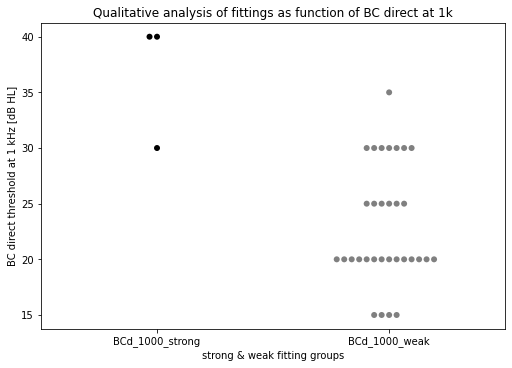

In [33]:
sw1k = sw[['BCd_1000_strong', 'BCd_1000_weak']]

# make a figure to plot BC direct threshold at 3 kHz for strong & weak fitting groups
ttl = 'Qualitative analysis of fittings as function of BC direct at 1k'

tp = pd.melt(sw1k, var_name = 'strong & weak fitting groups', value_name = 'BC direct threshold at 1 kHz [dB HL]') 

fig, ax = plt.subplots(constrained_layout=True)

fig.set_figheight(5)
fig.set_figwidth(7)

ax = sns.swarmplot(data = tp, x = 'strong & weak fitting groups', y = 'BC direct threshold at 1 kHz [dB HL]', 
                   size=6, palette={'grey', 'black'})

ax.set_title(ttl)
#plt.legend(bbox_to_anchor=(0.15, 0.25), fontsize='large')

# save figure to file
plt.savefig('/media/guido/LACIE/Cingle_Guido/Analysis_results/strong_weak_1k_bcd_side.tiff', 
           transparent=False, dpi=500, bbox_inches="tight")

plt.show()

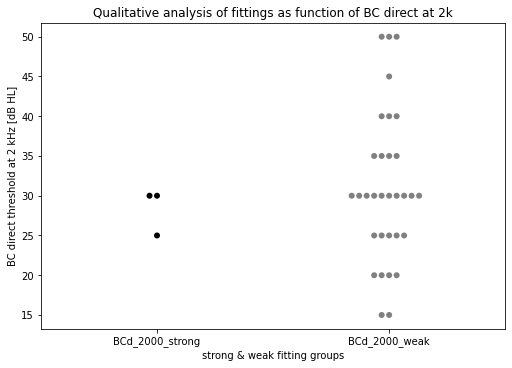

In [34]:
sw2k = sw[['BCd_2000_strong', 'BCd_2000_weak']]

# make a figure to plot BC direct threshold at 3 kHz for strong & weak fitting groups
ttl = 'Qualitative analysis of fittings as function of BC direct at 2k'

tp = pd.melt(sw2k, var_name = 'strong & weak fitting groups', value_name = 'BC direct threshold at 2 kHz [dB HL]') 

fig, ax = plt.subplots(constrained_layout=True)

fig.set_figheight(5)
fig.set_figwidth(7)

ax = sns.swarmplot(data = tp, x = 'strong & weak fitting groups', y = 'BC direct threshold at 2 kHz [dB HL]', 
                   size=6, palette={'grey', 'black'})

ax.set_title(ttl)
#plt.legend(bbox_to_anchor=(0.15, 0.25), fontsize='large')

# save figure to file
plt.savefig('/media/guido/LACIE/Cingle_Guido/Analysis_results/strong_weak_2k_bcd_side.tiff', 
           transparent=False, dpi=500, bbox_inches="tight")

plt.show()

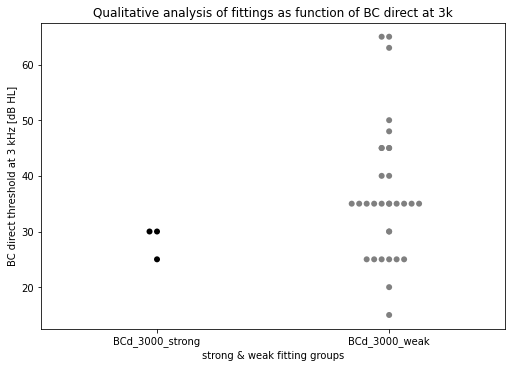

In [35]:
sw3k = sw[['BCd_3000_strong', 'BCd_3000_weak']]

# make a figure to plot BC direct threshold at 3 kHz for strong & weak fitting groups
ttl = 'Qualitative analysis of fittings as function of BC direct at 3k'

tp = pd.melt(sw3k, var_name = 'strong & weak fitting groups', value_name = 'BC direct threshold at 3 kHz [dB HL]') 

fig, ax = plt.subplots(constrained_layout=True)

fig.set_figheight(5)
fig.set_figwidth(7)

ax = sns.swarmplot(data = tp, x = 'strong & weak fitting groups', y = 'BC direct threshold at 3 kHz [dB HL]', 
                   size=6, palette={'grey', 'black'})

ax.set_title(ttl)
#plt.legend(bbox_to_anchor=(0.15, 0.25), fontsize='large')

# save figure to file
plt.savefig('/media/guido/LACIE/Cingle_Guido/Analysis_results/strong_weak_3k_bcd_side.tiff', 
           transparent=False, dpi=500, bbox_inches="tight")

plt.show()

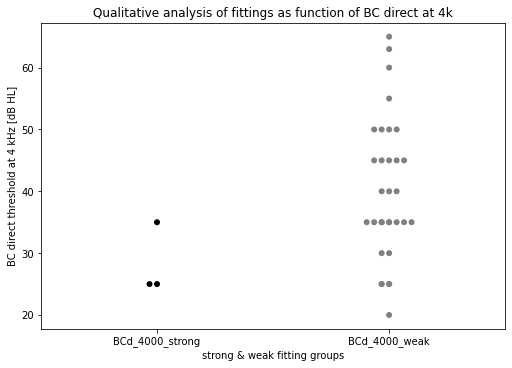

In [36]:
sw4k = sw[['BCd_4000_strong', 'BCd_4000_weak']]

# make a figure to plot BC direct threshold at 3 kHz for strong & weak fitting groups
ttl = 'Qualitative analysis of fittings as function of BC direct at 4k'

tp = pd.melt(sw4k, var_name = 'strong & weak fitting groups', value_name = 'BC direct threshold at 4 kHz [dB HL]') 

fig, ax = plt.subplots(constrained_layout=True)

fig.set_figheight(5)
fig.set_figwidth(7)

ax = sns.swarmplot(data = tp, x = 'strong & weak fitting groups', y = 'BC direct threshold at 4 kHz [dB HL]', 
                   size=6, palette={'grey', 'black'})

ax.set_title(ttl)
#plt.legend(bbox_to_anchor=(0.15, 0.25), fontsize='large')

# save figure to file
plt.savefig('/media/guido/LACIE/Cingle_Guido/Analysis_results/strong_weak_4k_bcd_side.tiff', 
           transparent=False, dpi=500, bbox_inches="tight")

plt.show()

In [37]:
bcb = bct_better2et3k()
bcb

Study_ID
1     False
2     False
6      True
10    False
12    False
      ...  
81    False
82    False
83    False
84    False
85     True
Name: BCd_<=30_2&3k, Length: 70, dtype: bool

In [38]:
td = [overall, bcb]
qlt = pd.DataFrame(td).T
qlt

,balanced & audible,BCd_<=30_2&3k
Study_ID,,
1,False,False
2,False,False
6,False,True
10,False,False
12,False,False
...,...,...
81,False,False
82,False,False
83,False,False


In [39]:
qlt = qlt.loc[idx_bh5]

In [40]:
# number of subjects with balanced en audible SL BC
qlt['balanced & audible'].sum()

3

In [41]:
# number of subjects fulfilling criterium BCdT 3 & 4 k
qlt['BCd_<=30_2&3k'].sum()

12

In [42]:
# number of subjects with balanced en audible SL BC fulfilling criterium BCdT 3 & 4 k
vrf = qlt['balanced & audible'] & qlt['BCd_<=30_2&3k']
vrf.sum()

3

In [43]:
# sensitivity
round(vrf.sum() / qlt['balanced & audible'].sum(),2)

1.0

In [44]:
# number of subjects with balanced en audible SL BC not fulfilling criterium BCdT 3 & 4 k
vrf2 = qlt['balanced & audible'] & ~qlt['BCd_<=30_2&3k']
vrf2.sum()

0

In [45]:
# number of subjects with NOT balanced en audible SL BC fulfilling criterium BCdT 3 & 4 k
vrf3 = ~qlt['balanced & audible'] & qlt['BCd_<=30_2&3k']
vrf3.sum()

9

In [46]:
# specificity %
negatieve = len(qlt) - qlt['balanced & audible'].sum()
thrue_neg = negatieve - vrf3.sum()
round(thrue_neg / negatieve, 2)

0.72